In [1]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
import pickle
from sklearn.manifold import TSNE, LocallyLinearEmbedding
from scipy.spatial.distance import pdist, squareform
from scipy import signal
# import skvideo.io
from openTSNE import TSNE as oTSNE
from openTSNE import  affinity
import math
import cv2
import os
from tqdm.notebook import trange, tqdm
# plt.switch_backend('Agg')


In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def calc_dist(data):
    dist = 1 - np.abs(np.corrcoef(data, rowvar=True))
    # eliminating pixels with nan distance. These are pixels who have not changed across all images. That is std = 0
    eleminated_pixel_idx = np.all(np.isnan(dist), axis=0)
    dist = dist[:, ~np.all(np.isnan(dist), axis=0)]
    dist = dist[~np.all(np.isnan(dist), axis=1), :]
    return dist, eleminated_pixel_idx

def compute_pos(dist, dim=2):
    """
    This function computes the positions of points in space from their distance matrix.
    https://math.stackexchange.com/questions/156161/finding-the-coordinates-of-points-from-distance-matrix
    http://www.galileoco.com/literature/OCRyoungHouseholder38.pdf
    :param dist: is a square distance matrix
    :param dim: dimention of the coord system
    :return: returns points coordinates
    """
    # ToDo: read on eigenvalue constraints and threasholding
    # http: // www.galileoco.com / literature / OCRyoungHouseholder38.pdf
    # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4303596/
    # https://dl.acm.org/citation.cfm?id=2398462
    # https://www.stat.berkeley.edu/~bickel/BL2008Aos-thresholding.pdf
    # use tSNE to project higher dimensions down to 2. http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html


    d1j2 = np.expand_dims(np.square(dist[0, :]), 0)
    di12 = np.expand_dims(np.square(dist[:, 0]), 1)
    dij2 = np.square(dist)
    M = (d1j2 + di12 - dij2)/2
    S, U = np.linalg.eig(M)
    return U * np.sqrt(S)

def create_disk_noise(a, b, n, num):
    """
    :param a: position
    :param b: position
    :param n: size
    :param num: number of images
    :return: 2D square array/image
    """
    y, x = np.ogrid[-a:n - a, -b:n - b]
    noise_coef = x * x + y * y
    noise = np.expand_dims(noise_coef, 2) * np.random.randn(n, n, num) / (n**2 * 100)
    return noise

def create_noisy_img(n, num):
    """
    :param n: size
    :param num: number of images
    :return: 2D square array/image
    """
    # creating kernel
    kernel_dim = 9

    # creating a center heavy kernel
    y, x = np.ogrid[-kernel_dim/2:kernel_dim/2, -kernel_dim/2:kernel_dim/2]
    x += 0.5
    y += 0.5
    conv_kernel2 = x * x + y * y
    conv_kernel2 = 1 / (conv_kernel2 + 1)
    conv_kernel2 /= np.sum(conv_kernel2)

    # creating a uniform kernel
    conv_kernel = np.ones((kernel_dim, kernel_dim))/(kernel_dim**2)

    # creating noisy images
    noise = np.random.rand(n, n, num) * 4
    # running the kernel over each noisy image
    convolved_imgs = []
    for i in range(noise.shape[-1]):
        convolved_imgs.append(signal.convolve2d(noise[..., i], conv_kernel2, boundary='symm', mode='same'))
    convolved_imgs = np.array(convolved_imgs)
    convolved_imgs = np.rollaxis(convolved_imgs, 0, 3)
    return convolved_imgs

def create_disk_image(a, b, n, r):
    """
    :param a: position
    :param b: position
    :param n: size
    :param r: radius
    :return: 2D square array/image
    """
    y, x = np.ogrid[-a:n - a, -b:n - b]
    mask = x * x + y * y <= r * r
    array = np.ones((n, n))
    array[mask] = 0
    return array

def create_test_image(dim):
    """
    Creates a square image that is useful for visual inspection of unscrambler performance.

    :param dim: dimension of image
    :return: 2D array of size (dim dim)
    """
    image = np.arange(0, 1, 1 / (dim ** 2 - 0.5)).astype(np.float32)
    diag_line = np.ones((dim, dim))
    np.fill_diagonal(diag_line, 0)
    image *= diag_line.flat
    image *= np.flipud(np.fliplr(np.tri(dim, k=18))).flat
    image *= create_disk_image(dim/2, dim/2, dim, 5).flat
    return image

def plot_3d():
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax3D = fig.add_subplot(111, projection='3d')
    ax3D.scatter(positions_embd[:, 0], positions_embd[:, 1], positions_embd[:, 2], s=8, c=test_image[~bad_pixel_idx])
    plt.show()

In [22]:
channels.shape

(3, 10000, 1024)

In [7]:
"""Get CIFAR-10"""
file_path = "./mldata/cifar-10-batches-py/data_batch_1"
data = unpickle(file_path)
images = np.array(data[b'data'])
channels = np.array(np.split(images, 3, 1))
cifar_grey = np.mean(channels, 0)

images = cifar_grey
image_dim = int(np.sqrt(len(images[0])))
num_of_images = 100

# making the random numbers predictable!
np.random.seed(40)

# pick to random images
indices = np.random.choice(len(images), num_of_images, replace=False)
picked_images = np.array([images[i] for i in indices]).astype(np.double)/(255)

picked_images = picked_images.transpose()
# Corner occlusion: sets the corner of all images to zero. Causing the algorithm to cut the out.
# picked_images *= np.reshape(np.flipud(np.tri(image_dim, k=18)), (image_dim**2, 1))

# make pixels zero in a checkerboard fashion
checkerboard = np.zeros((image_dim, image_dim),dtype=int)
checkerboard[1::2, ::2] = 1
checkerboard[::2, 1::2] = 1
# picked_images *= np.reshape(checkerboard, (image_dim**2, 1))

# disk occlusion:
# picked_images *= np.reshape(create_disk_image(image_dim/2, image_dim/2, image_dim, 4), (image_dim**2, 1))

# Adding noise
#picked_images += np.reshape(create_disk_noise(image_dim/2, image_dim/2, image_dim, num_of_images), (image_dim**2, -1))
#picked_images += np.reshape(create_noisy_img(image_dim, num_of_images), (image_dim**2, num_of_images))


dist_mat, bad_pixel_idx = calc_dist(picked_images)

In [8]:
picked_images.shape

(1024, 100)

/var/folders/y6/h36z2y61059c6_9bqpb2f_9r0000gn/T/ipykernel_6572/3545548539.py:36: RuntimeWarning: invalid value encountered in sqrt
  return U * np.sqrt(S)
Attempting to use `pca` initalization, but no `X` matrix specified! Using `spectral` initilization instead, which doesn't need access to the data matrix


Open TSNE
--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, metric='precomputed', n_iter=300, perplexity=24.0,
     verbose=True)
--------------------------------------------------------------------------------
===> Calculating spectral initialization...
   --> Time elapsed: 0.04 seconds
===> Running optimization with exaggeration=12.00, lr=85.33 for 250 iterations...
Iteration   50, KL divergence -0.5372, 50 iterations in 0.4637 sec
Iteration  100, KL divergence -4.9341, 50 iterations in 0.2819 sec
Iteration  150, KL divergence 0.0516, 50 iterations in 0.2644 sec
Iteration  200, KL divergence 0.0516, 50 iterations in 0.2639 sec
Iteration  250, KL divergence 0.0516, 50 iterations in 0.2639 sec
   --> Time elapsed: 1.54 seconds
===> Running optimization with exaggeration=1.00, lr=1024.00 for 300 iterations...
Iteration   50, KL divergence 0.0486, 50 iterations in 0.3122 sec
Iteration  100, KL divergence 0.0480, 50 iterations in 

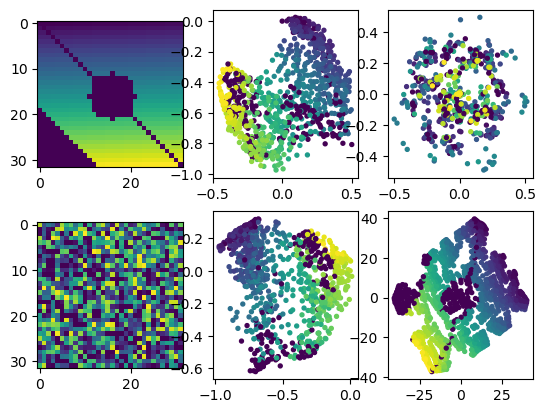

In [9]:
positions = np.real(compute_pos(dist_mat))
positions = positions[:, ~np.all(np.isnan(positions), axis=0)]
std_in_pos = np.nanstd(positions[:, 0:100], 0)
sort_index = np.argsort(std_in_pos)[-20:]
# positions_embd = TSNE(n_components=2, verbose=True, metric="precomputed", perplexity=24.0, n_iter=300, init="random").fit_transform(dist_mat)
print('Open TSNE')
af = affinity.PrecomputedAffinities(dist_mat, normalize=True)
positions_embd = oTSNE(n_components=2, verbose=True,  perplexity=24.0, n_iter=300,  metric="precomputed").fit(affinities=af)
embedding_dist = squareform(pdist(positions_embd))

#positions_embd = LocallyLinearEmbedding(n_neighbors=120, n_components=2, method="modified").fit_transform(positions[:, sort_index])

#plt.hist(dist_mat.flat, 51)
#plt.show()

# create test image
test_image = create_test_image(image_dim)

# plot_3d()

# create scrambling scheme and scrambling the data
scrambling_order = np.random.permutation(image_dim**2)
picked_images_scrm = picked_images[scrambling_order, :]
test_image_scrm = test_image[scrambling_order]


dist_mat_scrm, bad_pixel_idx_scrm = calc_dist(picked_images_scrm)
positions_scrm = np.real(compute_pos(dist_mat_scrm))
positions_scrm = positions_scrm[:, ~np.all(np.isnan(positions_scrm), axis=0)]
std_in_pos_scrm = np.nanstd(positions_scrm[:, 0:100], 0)
sort_index_scrm = np.argsort(std_in_pos_scrm)[-20:]
#positions_scrm_embd = TSNE(n_components=2, verbose=True).fit_transform(positions_scrm[:, sort_index_scrm])
print('SKLearn TSNE')
positions_scrm_embd = TSNE(n_components=2, verbose=True, metric="precomputed", perplexity=24.0, n_iter=550, init="random").fit_transform(dist_mat_scrm)
# positions_scrm_embd = oTSNE(n_components=2, verbose=True, metric="precomputed", perplexity=24.0, n_iter=1).fit(dist_mat_scrm)

f, ((ax1, ax2, ax_tnse1), (ax3, ax4, ax_tnse2)) = plt.subplots(2, 3, sharey=False)
ax1.imshow(test_image.reshape(image_dim, image_dim))
ax2.scatter(positions[:, sort_index[-1:]], positions[:, sort_index[-2:-1]], s=8, c=test_image[~bad_pixel_idx])
ax_tnse1.scatter(positions_embd[:, 0], positions_embd[:, 1], s=8, c=test_image[~bad_pixel_idx])
ax3.imshow(test_image_scrm.reshape(image_dim, image_dim))
ax4.scatter(positions_scrm[:, sort_index_scrm[-1:]], positions_scrm[:, sort_index_scrm[-2:-1]], s=8, c=test_image_scrm[~bad_pixel_idx_scrm])
ax_tnse2.scatter(positions_scrm_embd[:, 0], positions_scrm_embd[:, 1], s=8, c=test_image_scrm[~bad_pixel_idx_scrm])
plt.show()


## Plan 1
- Use the "prepare initial -> optimize" workflow
- Do `prepare_initial`
- Call `optimize` with the initial Affinities


## Plan 2
- Use `dist_mat` and random initilization
- Do the 1st iteration and get the embeddings
- Use the embeddings as the initialization in the next iteration

In [9]:
steps = 10

fig, axes = plt.subplots(steps, 1, sharey=False, figsize=(1.5, 15))
positions_embd = oTSNE(n_components=2, verbose=True, metric="precomputed", perplexity=24.0, initialization='random').prepare_initial(dist_mat)
# positions_embd = positions_embd.optimize(n_iter=20, inplace=False)
for ax in axes:    

    positions_embd = positions_embd.optimize(n_iter=15, inplace=False, exaggeration=12)
    ax.scatter(positions_embd[:, 0], positions_embd[:, 1], s=8, c=test_image[~bad_pixel_idx])



===> Calculating affinity matrix...
   --> Time elapsed: 0.01 seconds
===> Running optimization with exaggeration=12.00, lr=85.33 for 15 iterations...
   --> Time elapsed: 0.04 seconds
===> Running optimization with exaggeration=12.00, lr=85.33 for 15 iterations...
   --> Time elapsed: 0.03 seconds
===> Running optimization with exaggeration=12.00, lr=85.33 for 15 iterations...
   --> Time elapsed: 0.03 seconds
===> Running optimization with exaggeration=12.00, lr=85.33 for 15 iterations...
   --> Time elapsed: 0.03 seconds
===> Running optimization with exaggeration=12.00, lr=85.33 for 15 iterations...
   --> Time elapsed: 0.03 seconds
===> Running optimization with exaggeration=12.00, lr=85.33 for 15 iterations...
   --> Time elapsed: 0.03 seconds
===> Running optimization with exaggeration=12.00, lr=85.33 for 15 iterations...
   --> Time elapsed: 0.03 seconds
===> Running optimization with exaggeration=12.00, lr=85.33 for 15 iterations...
   --> Time elapsed: 0.03 seconds
===> Runni

In [30]:
def dist_evolution(dist_mat, step):

    if step > 200:
        # Add noise
        # dist_mat += np.random.randn(*dist_mat.shape)/300
        
        # separate
        new_dist = (dist_mat[0, :] + 1 ) / 2
        dist_mat[0, 1:] = new_dist[1:]
        dist_mat[1:, 0] = new_dist[1:]
        pass
    
    dist_mat -= dist_mat.min()
    return dist_mat / dist_mat.max()

Standard deviation of embedding is greater than 0.0001. Initial embeddings with high variance may have display poor convergence.
Standard deviation of embedding is greater than 0.0001. Initial embeddings with high variance may have display poor convergence.


===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds


Standard deviation of embedding is greater than 0.0001. Initial embeddings with high variance may have display poor convergence.
Standard deviation of embedding is greater than 0.0001. Initial embeddings with high variance may have display poor convergence.
Standard deviation of embedding is greater than 0.0001. Initial embeddings with high variance may have display poor convergence.
Standard deviation of embedding is greater than 0.0001. Initial embeddings with high variance may have display poor convergence.
Standard deviation of embedding is greater than 0.0001. Initial embeddings with high variance may have display poor convergence.
Standard deviation of embedding is greater than 0.0001. Initial embeddings with high variance may have display poor convergence.
Standard deviation of embedding is greater than 0.0001. Initial embeddings with high variance may have display poor convergence.
Standard deviation of embedding is greater than 0.0001. Initial embeddings with high variance may

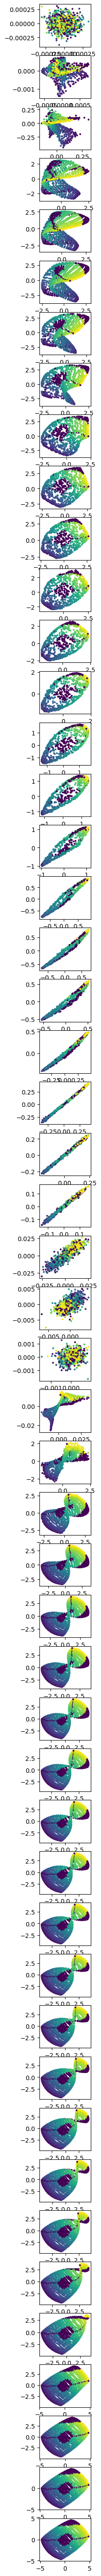

In [117]:
steps = 50
dist_mat_copy = dist_mat.copy()
fig, axes = plt.subplots(steps, 1, sharey=False, figsize=(1.5, np.ceil(1.5*steps)))
positions_embd = oTSNE(n_components=2, verbose=True, metric="precomputed", perplexity=4.0, initialization='random', n_iter=1).prepare_initial(dist_mat_copy)
for i, ax in enumerate(axes):    
    ax.scatter(positions_embd[:, 0], positions_embd[:, 1], s=4, c=test_image[~bad_pixel_idx])
    positions_embd = oTSNE(n_components=2, verbose=False, metric="precomputed", perplexity=4.0, initialization=positions_embd, n_iter=1).prepare_initial(dist_mat_copy)    
    positions_embd = positions_embd.optimize(n_iter=20, inplace=False, exaggeration=12)
    dist_mat_copy = dist_evolution(dist_mat_copy, i) if i < 25 else dist_mat.copy()


In [31]:
import logging
logger = logging.getLogger("mechanize")
# only log really bad events
logger.setLevel(logging.ERROR)

In [56]:
from moviepy.editor import VideoFileClip
# wiggle_clip = VideoFileClip("wiggling_1.3gp")
wiggle_clip = VideoFileClip("2023_A_scroll_scrolling_h2d4_optional_video_3.mp4")

wiggle_animation = VideoClip(wiggle_clip.get_frame, duration=7)
wiggle_animation.ipython_display(fps=15, loop=True, autoplay=True)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [72]:
wiggle_clip_resized = wiggle_clip.resize((144, 108))
wiggle_animation = VideoClip(wiggle_clip_resized.get_frame, duration=15)
wiggle_animation.ipython_display(fps=15, loop=True, autoplay=True)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [73]:
x1 = 50
y1 = 40
cropped_clip = wiggle_clip_resized.crop(x1, y1, x1+32, y1+32)
cropped_clip.size

(32, 32)

In [78]:
wiggle_frames = np.stack([f for f in cropped_clip.iter_frames()], axis=0)
make_frame = make_framer(wiggle_frames)
animation = VideoClip(make_frame, duration=10)
animation.ipython_display(fps=20, loop=True, autoplay=True)
# print('Num frames: ', len(wiggle_frames))

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [102]:
wiggle_frames_grey = np.mean(wiggle_frames, axis=-1)
wiggle_frames_grey = wiggle_frames_grey.reshape(wiggle_frames_grey.shape[0], -1)
print(wiggle_frames_grey.shape)
wiggle_dist_mat, bad_pixel_idx = calc_dist(wiggle_frames_grey[200:].T)
print('dist mat shape: ', wiggle_dist_mat.shape)

(2408, 1024)
dist mat shape:  (1024, 1024)


In [82]:
wiggle_frames.shape

(2408, 32, 32, 3)

In [36]:
test_image.shape

(1024,)

In [120]:
steps = 200
# dist_mat_copy = dist_mat.copy()
dist_mat_copy = wiggle_dist_mat.copy()
frames = []
positions_embd = oTSNE(n_components=2, verbose=False, metric="precomputed", perplexity=4.0, initialization='random', n_iter=1).prepare_initial(dist_mat_copy)
for i in trange(steps):
    fig, ax = plt.subplots(1, 1, sharey=False, figsize=(1.5, 1.5), dpi=200)
    # ax.scatter(positions_embd[:, 0], positions_embd[:, 1], s=4, c=test_image[~bad_pixel_idx])
    frame_colors = wiggle_frames[i+200].reshape(-1, 3) / 255 
    ax.scatter(positions_embd[:, 0], positions_embd[:, 1], s=4, c=frame_colors[~bad_pixel_idx], alpha=0.7)
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    fig.canvas.draw()
    plot_data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    frames.append(plot_data.reshape(fig.canvas.get_width_height()[::-1] + (3,)))
    plt.close()
    
    wiggle_dist_mat_new, bad_pixel_idx = calc_dist(wiggle_frames_grey[200+2*i:200+2*i+200].T)
    positions_embd = oTSNE(n_components=2, verbose=False, metric="precomputed", perplexity=10.0, initialization=positions_embd, n_iter=1).prepare_initial(wiggle_dist_mat_new)    
    positions_embd = positions_embd.optimize(n_iter=5, inplace=False, exaggeration=6)
    # dist_mat_copy = dist_evolution(dist_mat_copy, i) if i < 250 else dist_mat.copy()


  0%|          | 0/200 [00:00<?, ?it/s]

Standard deviation of embedding is greater than 0.0001. Initial embeddings with high variance may have display poor convergence.
Standard deviation of embedding is greater than 0.0001. Initial embeddings with high variance may have display poor convergence.
Standard deviation of embedding is greater than 0.0001. Initial embeddings with high variance may have display poor convergence.
Standard deviation of embedding is greater than 0.0001. Initial embeddings with high variance may have display poor convergence.
Standard deviation of embedding is greater than 0.0001. Initial embeddings with high variance may have display poor convergence.
Standard deviation of embedding is greater than 0.0001. Initial embeddings with high variance may have display poor convergence.
Standard deviation of embedding is greater than 0.0001. Initial embeddings with high variance may have display poor convergence.
Standard deviation of embedding is greater than 0.0001. Initial embeddings with high variance may

In [34]:
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

In [121]:
def make_framer(frames, count= -1):
    count = [-1]
    def make_frame(t):
        count[0] += 1
        return frames[count[0]]
    return make_frame  
    
make_frame = make_framer(frames)
animation = VideoClip(make_frame, duration=5)
animation.ipython_display(fps=10, loop=True, autoplay=True)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
